In [1]:
%cd ..

/home/vagrant/Development/advent-of-code-2022/python


In [2]:
%matplotlib inline

In [3]:
from inspect import cleandoc
from aocd import get_data
import ipytest
ipytest.autoconfig()

data = get_data(year=2022, day=23)

In [7]:
from aoc22.geometry import Direction, Point, Rotation, Rectangle
from collections import Counter, deque
from dataclasses import dataclass, field
from itertools import product, takewhile
from more_itertools import first, iterate, windowed, windowed_complete, last

def dedup(proposals):
    proposal_count = Counter(proposals.values())
    return {
        elf: p if proposal_count[p] == 1 else elf
        for elf, p in proposals.items()
    }
    
@dataclass(frozen=True)
class State:
    elves: set[Point]
    direction_priority: deque[Direction] = field(default_factory=lambda: deque([Direction.U, Direction.D, Direction.L, Direction.R]))
    
    ALL_DIRECTIONS = {
        Point(x, y)
        for x, y in product([-1, 0, 1], repeat=2)
        if abs(x) + abs(y) > 0
    }
    
    @classmethod
    def parse(cls, text: str, direction_priority=None):
        if not direction_priority:
            direction_priority = deque([Direction.U, Direction.D, Direction.L, Direction.R])
        return cls({
            Point(x, y)
            for y, line in enumerate(text.splitlines())
            for x, c in enumerate(line)
            if c == "#"
        }, direction_priority)
    
    def is_direction_available(self, elf, direction):
        return all(elf + direction + d not in self.elves for d in [Point(0, 0), Rotation.CLOCKWISE * direction, Rotation.COUNTERCLOCKWISE * direction])
    
    def proposal(self, elf):
        if any(elf + d in self.elves for d in State.ALL_DIRECTIONS):
            possible_proposals = (
                elf + direction
                for direction in self.direction_priority
                if self.is_direction_available(elf, direction)
            )
            return first(possible_proposals, elf)
        else:
            return elf
    
    def proposals(self):
        return {
            elf: self.proposal(elf)
            for elf in self.elves
        }

    def run(self, times: int = 1):
        result = self
        for _ in range(times):
            proposals = result.proposals()
            dp = deque(result.direction_priority)
            dp.rotate(-1)
            result = State(set(dedup(proposals).values()), dp)
        return result
    
    def run_until_stable(self):
        i, _ = last(takewhile(lambda x: x[1][0].elves != x[1][1].elves, enumerate(windowed(iterate(State.run, self), 2), start=2)))
        return i            
    
    def image(self):
        r = Rectangle.bounding_box(self.elves)
        return [
            [
                Point(x, y) in self.elves
                for x in range(r.lo.x, r.hi.x+1)
            ]
            for y in range(r.lo.y, r.hi.y+1)
        ]
    
    def empty_tile_count(self):
        r = Rectangle.bounding_box(self.elves)
        return r.area - len(self.elves)

data_state = State.parse(data)

In [8]:
%%ipytest
import pytest
from more_itertools import windowed

def small_example():
    return [
        State.parse(cleandoc("""
            .....
            ..##.
            ..#..
            .....
            ..##.
            .....
            """)),
        State.parse(cleandoc("""
            ..##.
            .....
            ..#..
            ...#.
            ..#..
            .....
            """), deque([Direction.D, Direction.L, Direction.R, Direction.U])),
        State.parse(cleandoc("""
            .....
            ..##.
            .#...
            ....#
            .....
            ..#..
            """), deque([Direction.L, Direction.R, Direction.U, Direction.D])),
        State.parse(cleandoc("""
            ..#..
            ....#
            #....
            ....#
            .....
            ..#..
            """), deque([Direction.R, Direction.U, Direction.D, Direction.L])),
    ]

@pytest.mark.parametrize("state, expected", list(windowed(small_example(), 2)))
def test_small_example(state, expected):
    assert expected.elves == state.run().elves

    
@pytest.fixture
def full_example():
    return State.parse(cleandoc("""
        ....#..
        ..###.#
        #...#.#
        .#...##
        #.###..
        ##.#.##
        .#..#..
        """))

def test_full_example(full_example):
    state = full_example.run(times=10)
    assert 110 == state.empty_tile_count()

def test_run_until_stable(full_example):
    assert 20 == full_example.run_until_stable()
    
                

.....                                                                                        [100%]
5 passed in 0.09s


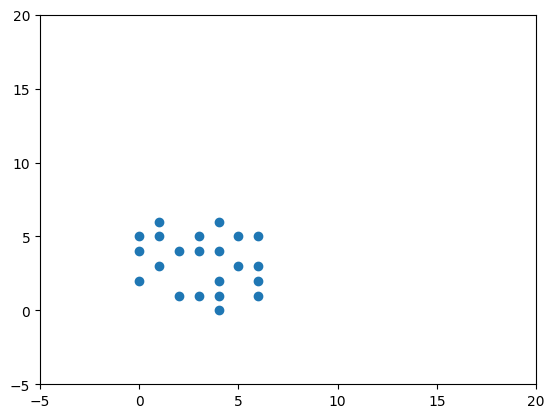

In [10]:
from matplotlib.pyplot import imshow, scatter, show, subplots
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

example_state = State.parse(cleandoc("""
        ....#..
        ..###.#
        #...#.#
        .#...##
        #.###..
        ##.#.##
        .#..#..
        """))

fig, ax = subplots()

ln = ax.scatter([], [])

ax.set_xlim(-5, 20)
ax.set_ylim(-5, 20)

def update(frame):
    state = example_state.run(frame)
    ln.set_offsets([elf.coords for elf in state.elves])
    return ln,

anim = FuncAnimation(fig, update, frames=21, interval=40)
HTML(anim.to_jshtml())

4236


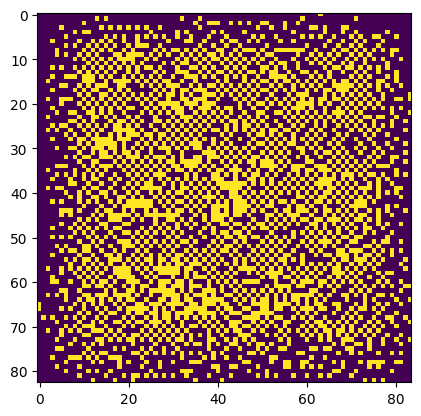

In [11]:
data_state10 = data_state.run(10)
print(data_state10.empty_tile_count())
imshow(data_state10.image())

In [40]:
data_state.run_until_stable()

1023